# Testing

In [ ]:
%cd ..

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import pickle
import copy
import collections

from Bio import SeqIO

from proteios.preprocess import preprocess, split_data
from proteios.featurise import Featuriser
from proteios.cross_val import cross_validate
from proteios.results import make_row, get_conf_matrix

# Fix random seed
np.random.seed(0)

### Get Data

In [3]:
input_path = "input_data/"

In [4]:
classes = ["Cytosolic", "Secreted", "Mitochondrial", "Nuclear"]

# Get dictionaries for labels
label2index = {key:i for i, key in enumerate(classes)}
index2label = dict(zip(label2index.values(), label2index.keys())) 

# Get data
datasets = dict()
for label in classes:
    datasets[label] = list(SeqIO.parse(input_path+label+".fasta", "fasta"))
# Get test data
blind_test_x = list(SeqIO.parse(input_path+"blind_test.fasta", "fasta"))

# Get number of examples in each category
counts = {key:len(val) for i, (key,val) in enumerate(datasets.items())}
counts["total"] = sum([len(sublist) for keys, sublist in datasets.items()])
print(label2index)
print(counts)
print("Number of test data points:  ", len(blind_test_x))

{'Cytosolic': 0, 'Secreted': 1, 'Mitochondrial': 2, 'Nuclear': 3}
{'Cytosolic': 3004, 'Secreted': 1605, 'Mitochondrial': 1299, 'Nuclear': 3314, 'total': 9222}
Number of test data points:   20


In [5]:
# Preprocess the data
full_x, full_y = preprocess(datasets, 
                            label2index=label2index,
                            trim_outliers=True,
                            max_length=2000)
print()
blind_test_xs = preprocess(blind_test_x, 
                           trim_outliers=True,
                           max_length=2000)
# Split the data
train_x, train_y, test_x, test_y = split_data(full_x, 
                                              full_y,
                                              train_size=0.9)
print()
print("Distribution Full:  ", dict(collections.Counter(full_y)))
print()
print("Training data size: ", len(train_y))
print("Test data size:     ", len(test_y))
print("Distribution train: ", dict(collections.Counter(train_y)))
print("Distribution test:  ", dict(collections.Counter(test_y)))

Processing Cytosolic
Data removed:  80
Processing Secreted
Data removed:  19
Processing Mitochondrial
Data removed:  2
Processing Nuclear
Data removed:  66
Total Before:  9222
Total After:   9055

Processing tmp
Data removed:  0
Total Before:  20
Total After:   20

Distribution Full:   {3: 3248, 0: 2924, 2: 1297, 1: 1586}

Training data size:  8148
Test data size:      907
Distribution train:  {1: 1427, 2: 1167, 3: 2923, 0: 2631}
Distribution test:   {3: 325, 0: 293, 1: 159, 2: 130}


### Get Features

In [6]:
# Get dictionaries
dicts = dict()
dicts['kd'] = pickle.load(open("input_data/scales/kd.pickle","rb"))
dicts['flex'] = pickle.load(open("input_data/scales/flex.pickle","rb"))
dicts['hw'] = pickle.load(open("input_data/scales/hw.pickle","rb"))
dicts['em'] = pickle.load(open("input_data/scales/em.pickle","rb"))
dicts['ja'] = pickle.load(open("input_data/scales/ja.pickle","rb"))
dicts['diwv'] = pickle.load(open("input_data/scales/diwv.pickle","rb"))  

In [7]:
featuriser = Featuriser(full_x, dicts)
full_x  = featuriser.transform(full_x)
blind_test_x  = featuriser.transform(blind_test_xs)
train_x = featuriser.transform(train_x)
test_x  = featuriser.transform(test_x)

In [8]:
train_x.head()

,length,molecular_weight,isoelectric_point,aromaticity,instability_index,gravy,reduced,oxidised,helix,turn,...,last_50_M,last_50_N,last_50_P,last_50_Q,last_50_R,last_50_S,last_50_T,last_50_V,last_50_W,last_50_Y
0,-0.806657,-0.800262,-0.755535,0.242616,-0.007247,0.305557,-0.509198,-0.508647,0.225385,0.012791,...,0.854124,-0.162842,0.138739,-0.110699,-0.806124,1.403898,-0.862108,-0.952807,0.422678,1.064776
1,-1.098142,-1.107773,1.170813,-1.528243,1.152644,0.437546,-0.901343,-0.906719,-0.683724,-0.370318,...,-0.016389,-0.162842,-0.289219,1.401648,0.907851,-0.787258,0.793750,-0.426707,1.502267,-0.978975
2,0.204178,0.224480,-0.802786,-0.099287,0.501211,0.927303,-0.435840,-0.429789,1.107682,-1.160093,...,-0.886903,-1.227841,2.278529,0.897533,-0.806124,-0.056872,-0.862108,-0.426707,-0.656912,-0.297724
3,0.046402,0.014496,1.297457,-1.188117,0.861330,0.038925,-0.447164,-0.428812,-1.140829,0.386568,...,2.595151,0.369657,3.990361,-0.614815,-0.806124,-0.422065,1.345703,0.099393,0.422678,-0.978975
4,0.899461,0.985599,-0.890165,1.067473,-0.433540,0.389393,0.506489,0.504784,1.612466,-0.363544,...,0.854124,-0.695342,-1.145135,-0.110699,0.907851,-0.787258,-0.862108,1.151592,0.422678,0.383526


# Models

In [9]:
table = collections.defaultdict(list)
columns = ['params', 
           'mean_test_Accuracy', 'std_test_Accuracy', 
           'mean_test_Precision', 'std_test_Precision',
           'mean_test_Recall', 'std_test_Recall',
           'mean_test_F1', 'std_test_F1',
           'mean_test_MCC', 'std_test_MCC']

### Test using Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Define some hyperparameters we are going to test
param_dist = {"n_estimators": [1000]}

# Make a handle for our model (initialization or our model without fitted parameters)
rf = RandomForestClassifier(random_state=79)

rf_random_search_res = cross_validate(rf,
                                      full_x,
                                      full_y,
                                      param_dist,
                                      5)

print("Best performance: %s" % (rf_random_search_res.best_score_))
print("With the hyperparameters: %s" % (rf_random_search_res.best_params_))

# Print cross-validation results
rf_df = pd.DataFrame.from_dict(rf_random_search_res.cv_results_)[columns].round(4)
rf_result = rf_df[rf_df['params']==rf_random_search_res.best_params_].reset_index(drop=True).to_dict('records')[0]
table = make_row(table, rf_result, "RF")
rf_df.T

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, Accuracy=0.674, F1=0.688, MCC=0.541, Precision=0.702, Recall=0.679, total=  40.7s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.7s remaining:    0.0s


[CV]  n_estimators=1000, Accuracy=0.680, F1=0.691, MCC=0.551, Precision=0.701, Recall=0.686, total=  41.2s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV]  n_estimators=1000, Accuracy=0.654, F1=0.674, MCC=0.516, Precision=0.676, Recall=0.672, total=  40.3s
[CV] n_estimators=1000 ...............................................
[CV]  n_estimators=1000, Accuracy=0.662, F1=0.687, MCC=0.525, Precision=0.699, Recall=0.678, total=  41.2s
[CV] n_estimators=1000 ...............................................
[CV]  n_estimators=1000, Accuracy=0.667, F1=0.687, MCC=0.533, Precision=0.694, Recall=0.682, total=  40.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min finished


Best performance: 0.6672556598564329
With the hyperparameters: {'n_estimators': 1000}


,0
params,{'n_estimators': 1000}
mean_test_Accuracy,0.6673
std_test_Accuracy,0.009
mean_test_Precision,0.6943
std_test_Precision,0.0096
mean_test_Recall,0.6794
std_test_Recall,0.0045
mean_test_F1,0.6854
std_test_F1,0.006
mean_test_MCC,0.5332


### Test using MLP

In [11]:
from sklearn.neural_network import MLPClassifier

# Define some hyperparameters we are going to test
param_dist = {"hidden_layer_sizes": [100,128,256,512]}

# Make a handle for our model (initialization or our model without fitted parameters)
mlp = MLPClassifier(random_state=79)

mlp_random_search_res = cross_validate(mlp,
                                       full_x,
                                       full_y,
                                       param_dist,
                                       5)

print("Best pemlpormance: %s" % (mlp_random_search_res.best_score_))
print("With the hyperparameters: %s" % (mlp_random_search_res.best_params_))

# Print cross-validation results
mlp_df = pd.DataFrame.from_dict(mlp_random_search_res.cv_results_)[columns].round(4)
mlp_result = mlp_df[mlp_df['params']==mlp_random_search_res.best_params_].reset_index(drop=True).to_dict('records')[0]
table = make_row(table, mlp_result, "MLP")
mlp_df.T

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] hidden_layer_sizes=100 ..........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV]  hidden_layer_sizes=100, Accuracy=0.624, F1=0.642, MCC=0.475, Precision=0.641, Recall=0.644, total=   7.1s
[CV] hidden_layer_sizes=100 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s


[CV]  hidden_layer_sizes=100, Accuracy=0.617, F1=0.638, MCC=0.464, Precision=0.641, Recall=0.635, total=   7.1s
[CV] hidden_layer_sizes=100 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=100, Accuracy=0.602, F1=0.626, MCC=0.446, Precision=0.626, Recall=0.627, total=   8.4s
[CV] hidden_layer_sizes=100 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=100, Accuracy=0.610, F1=0.627, MCC=0.454, Precision=0.629, Recall=0.624, total=  10.2s
[CV] hidden_layer_sizes=100 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=100, Accuracy=0.586, F1=0.604, MCC=0.421, Precision=0.608, Recall=0.601, total=   7.8s
[CV] hidden_layer_sizes=128 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=128, Accuracy=0.600, F1=0.625, MCC=0.442, Precision=0.626, Recall=0.624, total=   9.4s
[CV] hidden_layer_sizes=128 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=128, Accuracy=0.605, F1=0.625, MCC=0.447, Precision=0.629, Recall=0.621, total=   8.9s
[CV] hidden_layer_sizes=128 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=128, Accuracy=0.606, F1=0.630, MCC=0.448, Precision=0.634, Recall=0.627, total=   8.2s
[CV] hidden_layer_sizes=128 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=128, Accuracy=0.612, F1=0.628, MCC=0.459, Precision=0.626, Recall=0.631, total=   8.5s
[CV] hidden_layer_sizes=128 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=128, Accuracy=0.606, F1=0.624, MCC=0.448, Precision=0.629, Recall=0.620, total=   8.1s
[CV] hidden_layer_sizes=256 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=256, Accuracy=0.627, F1=0.650, MCC=0.479, Precision=0.651, Recall=0.650, total=  12.8s
[CV] hidden_layer_sizes=256 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=256, Accuracy=0.617, F1=0.639, MCC=0.465, Precision=0.641, Recall=0.637, total=  13.0s
[CV] hidden_layer_sizes=256 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=256, Accuracy=0.602, F1=0.627, MCC=0.445, Precision=0.627, Recall=0.627, total=  12.8s
[CV] hidden_layer_sizes=256 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=256, Accuracy=0.627, F1=0.650, MCC=0.478, Precision=0.653, Recall=0.648, total=  12.7s
[CV] hidden_layer_sizes=256 ..........................................


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=256, Accuracy=0.609, F1=0.627, MCC=0.451, Precision=0.632, Recall=0.623, total=  12.9s
[CV] hidden_layer_sizes=512 ..........................................
[CV]  hidden_layer_sizes=512, Accuracy=0.626, F1=0.651, MCC=0.477, Precision=0.651, Recall=0.650, total=  18.2s
[CV] hidden_layer_sizes=512 ..........................................
[CV]  hidden_layer_sizes=512, Accuracy=0.642, F1=0.658, MCC=0.499, Precision=0.658, Recall=0.657, total=  16.9s
[CV] hidden_layer_sizes=512 ..........................................
[CV]  hidden_layer_sizes=512, Accuracy=0.613, F1=0.642, MCC=0.460, Precision=0.642, Recall=0.642, total=  19.0s
[CV] hidden_layer_sizes=512 ..........................................
[CV]  hidden_layer_sizes=512, Accuracy=0.625, F1=0.652, MCC=0.474, Precision=0.658, Recall=0.647, total=  22.1s
[CV] hidden_layer_sizes=512 ..........................................
[CV]  hidden_layer_sizes=512, Accuracy=0.615, F1=0.634, MCC=0.461, Precision=0.639, R

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.0min finished


Best pemlpormance: 0.6241855328547764
With the hyperparameters: {'hidden_layer_sizes': 512}


,0,1,2,3
params,{'hidden_layer_sizes': 100},{'hidden_layer_sizes': 128},{'hidden_layer_sizes': 256},{'hidden_layer_sizes': 512}
mean_test_Accuracy,0.608,0.6059,0.6163,0.6242
std_test_Accuracy,0.013,0.0037,0.0097,0.0102
mean_test_Precision,0.6291,0.6289,0.6407,0.6499
std_test_Precision,0.0124,0.0028,0.01,0.0079
mean_test_Recall,0.6261,0.6247,0.6369,0.6452
std_test_Recall,0.0142,0.0038,0.0108,0.0091
mean_test_F1,0.6275,0.6266,0.6387,0.6473
std_test_F1,0.0132,0.0021,0.0103,0.0082
mean_test_MCC,0.452,0.4489,0.4634,0.4742


### Test using SVM

In [12]:
from sklearn.svm import SVC

# Define some hyperparameters we are going to test
param_dist = {"C": [1,2,3,5,10]}

# Make a handle for our model (initialization or our model without fitted parameters)
svm = SVC(random_state=79)

svm_random_search_res = cross_validate(svm,
                                       full_x,
                                       full_y,
                                       param_dist,
                                       5)

print("Best performance: %s" % (svm_random_search_res.best_score_))
print("With the hyperparameters: %s" % (svm_random_search_res.best_params_))

# Print cross-validation results
svm_df = pd.DataFrame.from_dict(svm_random_search_res.cv_results_)[columns].round(4)
svm_result = svm_df[svm_df['params']==svm_random_search_res.best_params_].reset_index(drop=True).to_dict('records')[0]
table = make_row(table, svm_result, "SVM")
svm_df.T

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1, Accuracy=0.684, F1=0.705, MCC=0.558, Precision=0.706, Recall=0.704, total=   6.2s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV]  C=1, Accuracy=0.694, F1=0.710, MCC=0.572, Precision=0.713, Recall=0.707, total=   6.6s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.8s remaining:    0.0s


[CV]  C=1, Accuracy=0.661, F1=0.686, MCC=0.527, Precision=0.686, Recall=0.686, total=   6.4s
[CV] C=1 .............................................................
[CV]  C=1, Accuracy=0.664, F1=0.691, MCC=0.529, Precision=0.697, Recall=0.686, total=   6.8s
[CV] C=1 .............................................................
[CV]  C=1, Accuracy=0.669, F1=0.692, MCC=0.538, Precision=0.696, Recall=0.688, total=   6.8s
[CV] C=2 .............................................................
[CV]  C=2, Accuracy=0.697, F1=0.719, MCC=0.578, Precision=0.721, Recall=0.718, total=   6.2s
[CV] C=2 .............................................................
[CV]  C=2, Accuracy=0.697, F1=0.712, MCC=0.576, Precision=0.714, Recall=0.710, total=   6.2s
[CV] C=2 .............................................................
[CV]  C=2, Accuracy=0.668, F1=0.693, MCC=0.537, Precision=0.692, Recall=0.694, total=   6.3s
[CV] C=2 .............................................................
[CV]  C=2, Accur

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.0min finished


Best performance: 0.6800662617338487
With the hyperparameters: {'C': 2}


,0,1,2,3,4
params,{'C': 1},{'C': 2},{'C': 3},{'C': 5},{'C': 10}
mean_test_Accuracy,0.6743,0.6801,0.678,0.669,0.6616
std_test_Accuracy,0.0126,0.0139,0.0094,0.0084,0.0102
mean_test_Precision,0.6998,0.705,0.7034,0.6959,0.6892
std_test_Precision,0.0093,0.0113,0.0092,0.006,0.0081
mean_test_Recall,0.6942,0.7005,0.6991,0.6904,0.682
std_test_Recall,0.0093,0.0116,0.0071,0.0071,0.0086
mean_test_F1,0.6965,0.7023,0.7008,0.6928,0.6852
std_test_F1,0.0089,0.0113,0.0079,0.0061,0.0083
mean_test_MCC,0.5447,0.5532,0.5503,0.5375,0.5268


### Test using GNB

In [13]:
from sklearn.naive_bayes import GaussianNB
# Define some hyperparameters we are going to test
param_dist = {"priors":[None]}

# Make a handle for our model (initialization or our model without fitted parameters)
gnb = GaussianNB()

gnb_random_search_res = cross_validate(gnb,
                                       full_x,
                                       full_y,
                                       param_dist,
                                       5)

print("Best pegnbormance: %s" % (gnb_random_search_res.best_score_))
print("With the hyperparameters: %s" % (gnb_random_search_res.best_params_))

# Print cross-validation results
gnb_df = pd.DataFrame.from_dict(gnb_random_search_res.cv_results_)[columns].round(4)
gnb_result = gnb_df[gnb_df['params']==gnb_random_search_res.best_params_].reset_index(drop=True).to_dict('records')[0]
table = make_row(table, gnb_result, "GNB")
gnb_df.T

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] priors=None .....................................................
[CV]  priors=None, Accuracy=0.544, F1=0.555, MCC=0.390, Precision=0.562, Recall=0.582, total=   0.0s
[CV] priors=None .....................................................
[CV]  priors=None, Accuracy=0.545, F1=0.554, MCC=0.390, Precision=0.559, Recall=0.582, total=   0.0s
[CV] priors=None .....................................................
[CV]  priors=None, Accuracy=0.538, F1=0.554, MCC=0.383, Precision=0.562, Recall=0.584, total=   0.0s
[CV] priors=None .....................................................
[CV]  priors=None, Accuracy=0.535, F1=0.552, MCC=0.372, Precision=0.558, Recall=0.576, total=   0.0s
[CV] priors=None .....................................................
[CV]  priors=None, Accuracy=0.543, F1=0.560, MCC=0.389, Precision=0.573, Recall=0.585, total=   0.0s
Best pegnbormance: 0.5410270568746548
With the hyperparameters: {'priors': None}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


,0
params,{'priors': None}
mean_test_Accuracy,0.541
std_test_Accuracy,0.004
mean_test_Precision,0.5628
std_test_Precision,0.0051
mean_test_Recall,0.5817
std_test_Recall,0.003
mean_test_F1,0.555
std_test_F1,0.0027
mean_test_MCC,0.3847


### Test using LDA

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Define some hyperparameters we are going to test
param_dist = {"priors":[None]}

# Make a handle for our model (initialization or our model without fitted parameters)
lda = LinearDiscriminantAnalysis()

lda_random_search_res = cross_validate(lda,
                                       full_x,
                                       full_y,
                                       param_dist,
                                       5)

print("Best peldaormance: %s" % (lda_random_search_res.best_score_))
print("With the hyperparameters: %s" % (lda_random_search_res.best_params_))

# Print cross-validation results
lda_df = pd.DataFrame.from_dict(lda_random_search_res.cv_results_)[columns].round(4)
lda_result = lda_df[lda_df['params']==lda_random_search_res.best_params_].reset_index(drop=True).to_dict('records')[0]
table = make_row(table, lda_result, "LDA")
lda_df.T

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] priors=None .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  priors=None, Accuracy=0.621, F1=0.637, MCC=0.472, Precision=0.640, Recall=0.636, total=   0.1s
[CV] priors=None .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  priors=None, Accuracy=0.624, F1=0.640, MCC=0.474, Precision=0.644, Recall=0.639, total=   0.1s
[CV] priors=None .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  priors=None, Accuracy=0.615, F1=0.634, MCC=0.462, Precision=0.641, Recall=0.631, total=   0.1s
[CV] priors=None .....................................................
[CV]  priors=None, Accuracy=0.599, F1=0.619, MCC=0.436, Precision=0.628, Recall=0.611, total=   0.2s
[CV] priors=None .....................................................
[CV]  priors=None, Accuracy=0.602, F1=0.621, MCC=0.442, Precision=0.629, Recall=0.615, total=   0.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Best peldaormance: 0.6121479845389288
With the hyperparameters: {'priors': None}


,0
params,{'priors': None}
mean_test_Accuracy,0.6121
std_test_Accuracy,0.0102
mean_test_Precision,0.6366
std_test_Precision,0.0066
mean_test_Recall,0.6266
std_test_Recall,0.0113
mean_test_F1,0.6301
std_test_F1,0.0086
mean_test_MCC,0.4571


### Test using KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Define some hyperparameters we are going to test
param_dist = {"n_neighbors":[1,2,3,4,5,6,7,8,9,10,15,20,25,30]}

# Make a handle for our model (initialization or our model without fitted parameters)
knn = KNeighborsClassifier()

knn_random_search_res = cross_validate(knn,
                                       full_x,
                                       full_y,
                                       param_dist,
                                       5)

print("Best peknnormance: %s" % (knn_random_search_res.best_score_))
print("With the hyperparameters: %s" % (knn_random_search_res.best_params_))

# Print cross-validation results
knn_df = pd.DataFrame.from_dict(knn_random_search_res.cv_results_)[columns].round(4)
knn_result = knn_df[knn_df['params']==knn_random_search_res.best_params_].reset_index(drop=True).to_dict('records')[0]
table = make_row(table, knn_result, "KNN")
knn_df.T

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=1, Accuracy=0.604, F1=0.617, MCC=0.445, Precision=0.628, Recall=0.610, total=   2.1s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  n_neighbors=1, Accuracy=0.578, F1=0.580, MCC=0.413, Precision=0.592, Recall=0.576, total=   2.1s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV]  n_neighbors=1, Accuracy=0.563, F1=0.578, MCC=0.391, Precision=0.590, Recall=0.572, total=   2.0s
[CV] n_neighbors=1 ...................................................
[CV]  n_neighbors=1, Accuracy=0.581, F1=0.591, MCC=0.415, Precision=0.601, Recall=0.586, total=   2.1s
[CV] n_neighbors=1 ...................................................
[CV]  n_neighbors=1, Accuracy=0.578, F1=0.585, MCC=0.413, Precision=0.594, Recall=0.581, total=   2.1s
[CV] n_neighbors=2 ...................................................
[CV]  n_neighbors=2, Accuracy=0.558, F1=0.562, MCC=0.406, Precision=0.620, Recall=0.558, total=   2.0s
[CV] n_neighbors=2 ...................................................
[CV]  n_neighbors=2, Accuracy=0.556, F1=0.556, MCC=0.406, Precision=0.615, Recall=0.556, total=   2.3s
[CV] n_neighbors=2 ...................................................
[CV]  n_neighbors=2, Accuracy=0.550, F1=0.556, MCC=0.398, Precision=0.613, Recall=0.558, total=   2.1s
[CV] n_neighbors=2 ........

[CV]  n_neighbors=15, Accuracy=0.624, F1=0.642, MCC=0.477, Precision=0.674, Recall=0.629, total=   2.2s
[CV] n_neighbors=15 ..................................................
[CV]  n_neighbors=15, Accuracy=0.621, F1=0.638, MCC=0.470, Precision=0.664, Recall=0.627, total=   2.1s
[CV] n_neighbors=15 ..................................................
[CV]  n_neighbors=15, Accuracy=0.628, F1=0.645, MCC=0.484, Precision=0.681, Recall=0.634, total=   2.0s
[CV] n_neighbors=15 ..................................................
[CV]  n_neighbors=15, Accuracy=0.608, F1=0.634, MCC=0.454, Precision=0.670, Recall=0.619, total=   2.0s
[CV] n_neighbors=15 ..................................................
[CV]  n_neighbors=15, Accuracy=0.616, F1=0.637, MCC=0.466, Precision=0.671, Recall=0.625, total=   2.0s
[CV] n_neighbors=20 ..................................................
[CV]  n_neighbors=20, Accuracy=0.618, F1=0.635, MCC=0.469, Precision=0.664, Recall=0.625, total=   2.1s
[CV] n_neighbors=20 .

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  2.5min finished


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
params,{'n_neighbors': 1},{'n_neighbors': 2},{'n_neighbors': 3},{'n_neighbors': 4},{'n_neighbors': 5},{'n_neighbors': 6},{'n_neighbors': 7},{'n_neighbors': 8},{'n_neighbors': 9},{'n_neighbors': 10},{'n_neighbors': 15},{'n_neighbors': 20},{'n_neighbors': 25},{'n_neighbors': 30}
mean_test_Accuracy,0.5809,0.5579,0.5991,0.5913,0.6027,0.6057,0.6125,0.6054,0.6172,0.6128,0.6193,0.613,0.6207,0.619
std_test_Accuracy,0.013,0.0073,0.0089,0.0066,0.0101,0.0032,0.008,0.0053,0.0053,0.0061,0.0068,0.0053,0.0068,0.0085
mean_test_Precision,0.6009,0.6188,0.6471,0.6448,0.6472,0.6619,0.6607,0.6587,0.6652,0.6634,0.672,0.6682,0.675,0.6762
std_test_Precision,0.0141,0.0062,0.0065,0.0071,0.0077,0.0029,0.0059,0.0064,0.0049,0.0071,0.0055,0.0027,0.0033,0.0055
mean_test_Recall,0.5851,0.5597,0.5981,0.5988,0.6091,0.6136,0.6208,0.6154,0.6242,0.6213,0.6268,0.6226,0.6267,0.6265
std_test_Recall,0.0134,0.005,0.0074,0.0042,0.0086,0.0031,0.0058,0.0059,0.0035,0.0069,0.0049,0.0043,0.0051,0.0069
mean_test_F1,0.5901,0.5607,0.6142,0.6092,0.6202,0.6253,0.6323,0.6256,0.6359,0.632,0.6392,0.634,0.639,0.6384
std_test_F1,0.0141,0.0056,0.0071,0.0052,0.0082,0.002,0.0056,0.0052,0.0035,0.006,0.0037,0.0035,0.0042,0.0063
mean_test_MCC,0.4153,0.4077,0.4405,0.4367,0.4478,0.4565,0.4609,0.4548,0.4674,0.4632,0.4704,0.4619,0.4723,0.4708


### Get Table

In [16]:
table = pd.DataFrame.from_dict(table)
print(table.to_latex())

\begin{tabular}{lllllll}
\toprule
{} & Model &   Accuracy (\%) &      Precision &         Recall &     F\$1\$-Score &            MCC \\
\midrule
0 &    RF &   0.6673±0.009 &  0.6943±0.0096 &  0.6794±0.0045 &   0.6854±0.006 &  0.5332±0.0123 \\
1 &   MLP &  0.6242±0.0102 &  0.6499±0.0079 &  0.6452±0.0091 &  0.6473±0.0082 &  0.4742±0.0142 \\
2 &   SVM &  0.6801±0.0139 &   0.705±0.0113 &  0.7005±0.0116 &  0.7023±0.0113 &  0.5532±0.0193 \\
3 &   GNB &    0.541±0.004 &  0.5628±0.0051 &   0.5817±0.003 &   0.555±0.0027 &   0.3847±0.007 \\
4 &   LDA &  0.6121±0.0102 &  0.6366±0.0066 &  0.6266±0.0113 &  0.6301±0.0086 &  0.4571±0.0155 \\
5 &   KNN &  0.6207±0.0068 &   0.675±0.0033 &  0.6267±0.0051 &   0.639±0.0042 &  0.4723±0.0094 \\
\bottomrule
\end{tabular}



### Re-run Random Forest with final hyperparameters

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, random_state=79)
mean_conf_matrix, std_conf_matrix, class_reports = get_conf_matrix(rf, 
                                                                   full_x.to_numpy(), 
                                                                   full_y, classes, 
                                                                   n_splits=5)
# Get labels for Confusion matrix plot
mean_str = mean_conf_matrix.astype(str)
std_str  = std_conf_matrix.astype(str)
labels = np.core.defchararray.add(mean_str,"±\n")
labels = np.core.defchararray.add(labels,std_str)

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, random_state=79)
rf.fit(full_x, full_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=79, verbose=0,
                       warm_start=False)

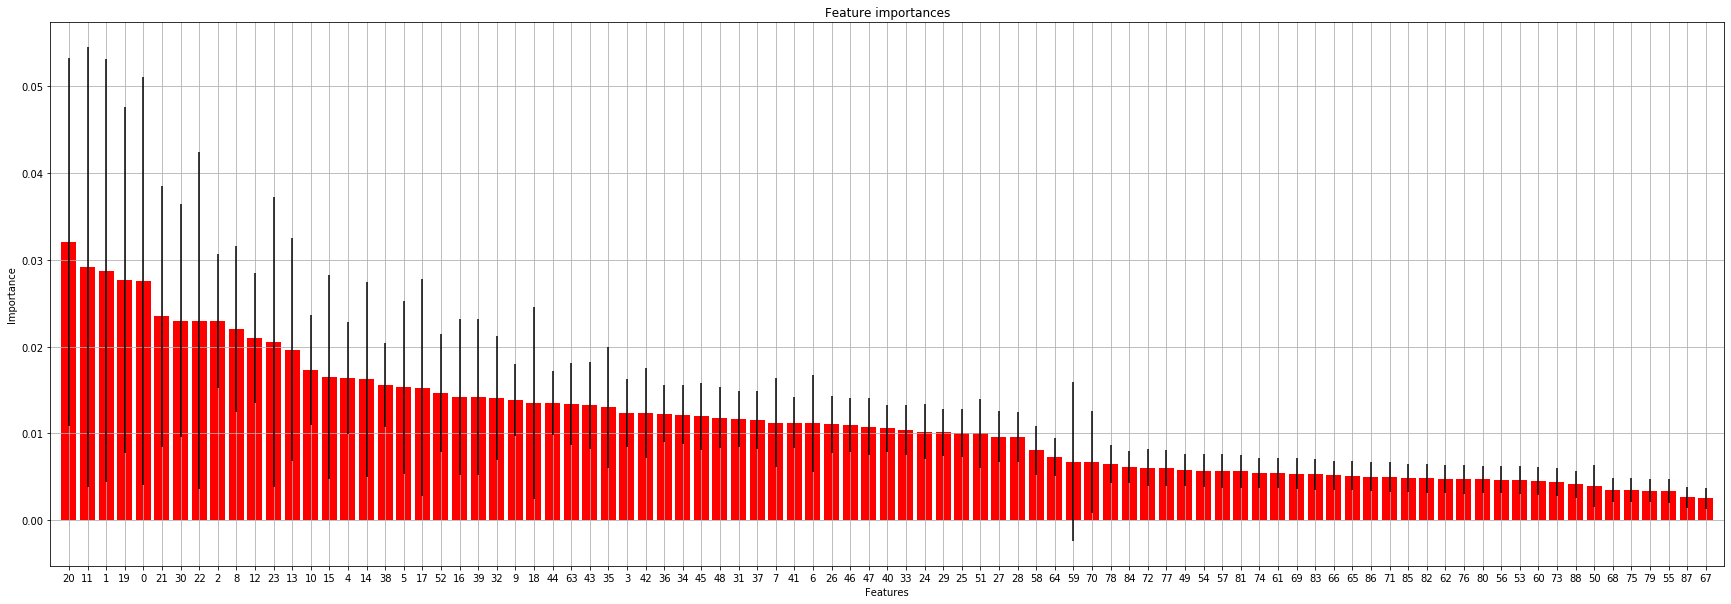

In [19]:
# Feature Importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(30,10))
plt.title("Feature importances")
plt.bar(range(train_x.shape[1]), 
        importances[indices], 
        color="r", yerr=std[indices], align="center")
plt.xticks(range(train_x.shape[1]), indices)
plt.xlim([-1, train_x.shape[1]])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid()
plt.show()

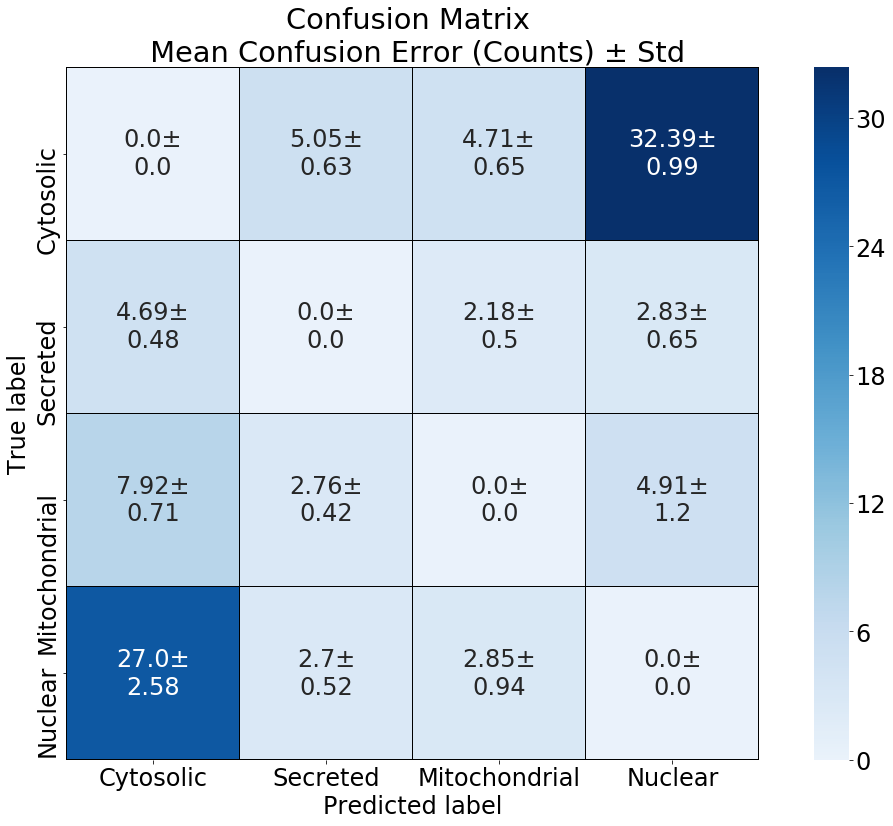

In [20]:
plt.rcParams.update({'font.size': 24})
# Plot averaged confusion matrix
df_cm = pd.DataFrame(mean_conf_matrix, 
                     index = classes,
                     columns = classes)
plt.figure(figsize = (16,12))
sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues',
            cbar=True, square=True, center=15,
            linewidths=.1, linecolor='black')
plt.ylim((4,0))
plt.title("Confusion Matrix \n Mean Confusion Error (Counts) ± Std")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
# plt.savefig("confusion_matrix.pdf", format="pdf")
plt.show()

In [21]:
# Classification Report
class_reports = np.array(class_reports)
pd.DataFrame(class_reports[:3,:]).T
print(pd.DataFrame(class_reports[:3,:], columns=classes).T.to_latex())

\begin{tabular}{llll}
\toprule
{} &                0 &                1 &                2 \\
\midrule
Cytosolic     &  0.5812\textbackslash pm0.0253 &  0.5657\textbackslash pm0.0227 &   0.573\textbackslash pm0.0197 \\
Secreted      &  0.8039\textbackslash pm0.0155 &  0.8159\textbackslash pm0.0091 &  0.8098\textbackslash pm0.0106 \\
Mitochondrial &    0.74\textbackslash pm0.0352 &   0.6384\textbackslash pm0.021 &   0.6847\textbackslash pm0.017 \\
Nuclear       &  0.6522\textbackslash pm0.0054 &  0.6976\textbackslash pm0.0269 &   0.674\textbackslash pm0.0139 \\
\bottomrule
\end{tabular}



### Test on blind test data

In [22]:
class_labels = ['Cyto', 'Secr', 'Mito', 'Nucl']
pred = rf.predict_proba(blind_test_x )
seq_id = [seq.id for seq in blind_test_xs]

In [23]:
blind_test_results = collections.defaultdict(list)
for i, seq in enumerate(seq_id):
    blind_test_results[seq].extend([class_labels[np.argmax(pred[i,:])], str(int((np.max(pred[i,:])*100).round(0)))])
pd.DataFrame.from_dict(blind_test_results).T

,0,1
SEQ677,Secr,40
SEQ231,Secr,57
SEQ871,Secr,55
SEQ388,Nucl,71
SEQ122,Nucl,69
SEQ758,Nucl,80
SEQ333,Cyto,43
SEQ937,Cyto,67
SEQ351,Cyto,45
SEQ202,Mito,72


In [24]:
print(pd.DataFrame.from_dict(blind_test_results).T.to_latex())

\begin{tabular}{lll}
\toprule
{} &     0 &   1 \\
\midrule
SEQ677 &  Secr &  40 \\
SEQ231 &  Secr &  57 \\
SEQ871 &  Secr &  55 \\
SEQ388 &  Nucl &  71 \\
SEQ122 &  Nucl &  69 \\
SEQ758 &  Nucl &  80 \\
SEQ333 &  Cyto &  43 \\
SEQ937 &  Cyto &  67 \\
SEQ351 &  Cyto &  45 \\
SEQ202 &  Mito &  72 \\
SEQ608 &  Mito &  79 \\
SEQ402 &  Mito &  70 \\
SEQ433 &  Nucl &  31 \\
SEQ821 &  Secr &  85 \\
SEQ322 &  Nucl &  91 \\
SEQ982 &  Nucl &  84 \\
SEQ951 &  Nucl &  46 \\
SEQ173 &  Nucl &  53 \\
SEQ862 &  Mito &  67 \\
SEQ224 &  Cyto &  37 \\
\bottomrule
\end{tabular}



In [25]:
# rf = SVC(C=5,random_state=79,probability=True)
rf = RandomForestClassifier(n_estimators=1000, random_state=79)
rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=79, verbose=0,
                       warm_start=False)

In [26]:
pred_proba_test = rf.predict_proba(test_x)
pred_proba_test_label = np.argmax(pred_proba_test,axis=1)
pred_proba_test_conf = np.max(pred_proba_test,axis=1)

In [27]:
pred_proba_test_conf[test_y!=pred_proba_test_label].mean()

0.4921821086261981

In [28]:
pred_proba_test_conf[test_y==pred_proba_test_label].mean()

0.5908821548821549